## Objective
    - implement version space for SVM and Boosting algorithms
    - verify how its volume changes after each iteration of the AL algorithm
    - check for possible optimizations

In [1]:
# set code path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import dataset: Housing
    - Size: 645 points, 7 dimensions
    - Preprocessing: each column is standardized
    - Positive samples query: x[2] + x[3] <= -85.7
    - Percentage of positive samples: 4.2 %

In [3]:
# import housing dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data = pd.read_csv("../data/housing/housing.data", header=None)
data = data[[2, 7]]

X_housing = data.values
X_housing_fit = scaler.fit_transform(X_housing) + [1,1]
y_housing = 2*(X_housing_fit[:,0] + X_housing_fit[:,1] <= 0) - 1
print("Percentage of positive samples: %.2f " % (100.0*(y_housing == 1).sum()/len(y_housing)))

Percentage of positive samples: 3.88 


In [4]:
# dataset shape
X_housing_fit.shape, y_housing.shape

((645, 2), (645,))

## Set up Active Learning module
    - Algorithm: Simple Margin with linear kernel (Tong and Koller)
    - We also compared with two other AL: Random and Solver Method
    - Initial sampling: one positive and one negative are randomly sampled
    - Only 50 samples are labeled at every run
    - Results are averaged over 30 runs
    - We compute the true accuracy and f1 scores against the entire dataset after each iteration

In [5]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=10000, fit_intercept=False)
clf.fit(X_housing_fit, y_housing)
print(clf.intercept_, clf.coef_/np.linalg.norm(clf.coef_))
(clf.predict(X_housing_fit) == y_housing).sum()/len(y_housing)

0.0 [[-0.69611237 -0.71793284]]


1.0

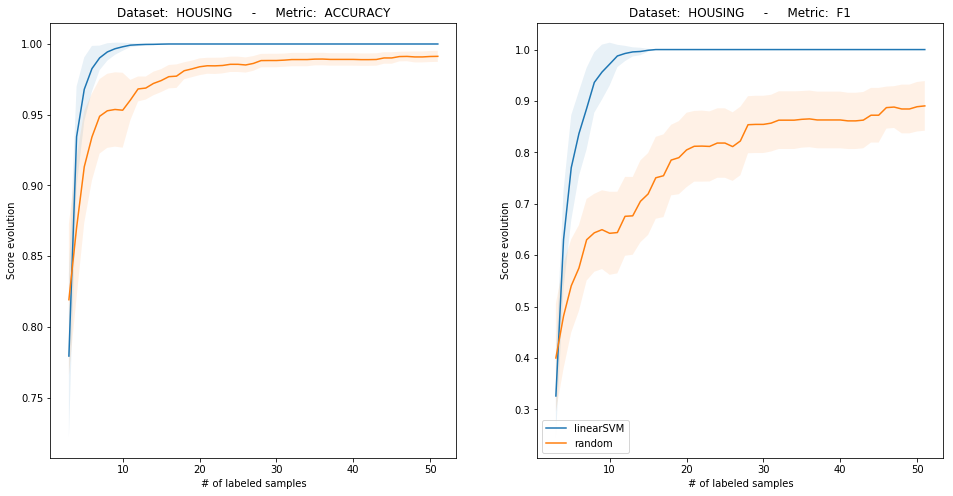

In [6]:
from sklearn.svm import LinearSVC
from src.user import DummyUser
from src.initial_sampling import FixedSizeStratifiedSampler
from src.showdown import Showdown
from src.plotting import plot_showdown

from src.active_learning.svm.linear import LinearSimpleMargin, LinearSolverMethod
from src.active_learning.agnostic import RandomLearner


# set user
max_iter = 50
user_housing = DummyUser(max_iter=max_iter, y_true=y_housing)

# AL list
active_learners_list = [
     ("random", RandomLearner(LinearSVC(C=10000, fit_intercept=False))),
     ("linearSVM", LinearSimpleMargin(C=10000, fit_intercept=False)),
     #("solver5", LinearSolverMethod(pool_size=5, C=10000, fit_intercept=False)),
     #("solver10", SolverMethod(pool_size=10, C=1000, fit_intercept=False)),
     #("solver20", SolverMethod(pool_size=20, C=1000, fit_intercept=False))
]

# datasets
datasets_list = [
    ("housing", X_housing_fit, user_housing)
]

# set showdown and run
times = 30
initial_sampler = FixedSizeStratifiedSampler(sample_size=2)
showdown = Showdown(times, initial_sampler)
output = showdown.run(datasets_list, active_learners_list)

# plot results
#print(output.head())
plot_showdown(output, times, metrics_list=['accuracy', 'f1'])

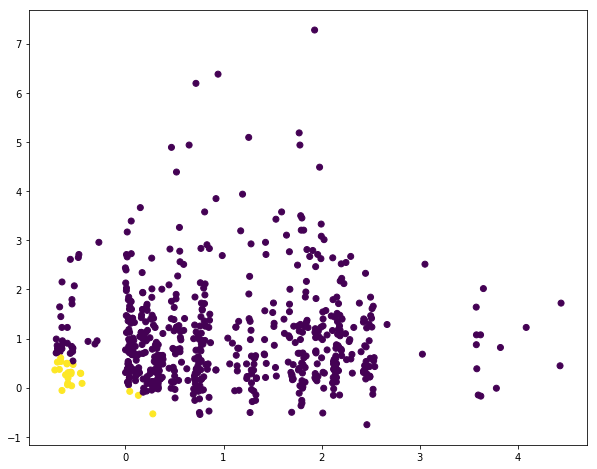

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(X_housing_fit[:,0], X_housing_fit[:,1], c=y_housing)
plt.show()

## 2-dimensional version space
    - Let's consider the simple case of Linear SVM for 2-dimensional input
    - Version Space = circle in R2
    - Easy to visualize and compute VS reduction per iteration

In [8]:
from src.version_space.two_dimensional import Angle, Point, Circle

point = Point(-2,0)
print("point = ", point)
print("ortogonal = ", point.orthogonal())
print("opposite = ", -point)
print("theta (rad) = ", point.angle.rad)
print("theta (deg) = ", point.angle.deg)
print("norm = ", point.norm)
print("normalized point = ", point.normalize())

point =  (-2.000, 0.000)
ortogonal =  (-0.000, -2.000)
opposite =  (2.000, -0.000)
theta (rad) =  3.141592653589793
theta (deg) =  180.0
norm =  2.0
normalized point =  (-1.000, 0.000)


In [12]:
vs = Circle()
print(vs)

points_list = [
    Point(1,0),
    Point(1,1),
    Point(1,-1),
    Point(0,1),
    Point(-1,-1)
]

for point in points_list:
    vs.cut(point)
    print(vs)

Limits: left = (1.000, 0.000), right = (1.000, 0.000), Size: 6.28319
Limits: left = (0.000, -1.000), right = (-0.000, 1.000), Size: 3.14159
Limits: left = (0.707, -0.707), right = (-0.000, 1.000), Size: 2.35619
Limits: left = (0.707, -0.707), right = (0.707, 0.707), Size: 1.57080
Limits: left = (1.000, -0.000), right = (0.707, 0.707), Size: 0.78540


RuntimeError: Point incompatible with current version space!

In [10]:
from matplotlib.patches import Arc

def plot_arc(ax, theta1=0, theta2=360, color='k', linewidth=2.0):
    arc_patch = Arc(xy=[0,0], width=2.0, height=2.0, angle=0.0, 
                    theta1=theta1, theta2=theta2, color=color, linewidth=linewidth)
    ax.add_patch(arc_patch)

def plot_version_space(vs, point=None):
    # start figure
    fig, ax = plt.subplots(figsize=(8,8))

    # set plot configs
    ax.set_title("Version Space")
    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))
    
    # if full version space, only draw circle
    if vs.is_full_circle():
        plot_arc(ax)
        return ax
    
    # get angle of VS delimiters
    th_e1 = vs.e1.theta()
    th0 = (vs.theta0 + th_e1) * 180 / math.pi
    th1 = (vs.theta1 + th_e1) * 180 / math.pi
    
    # plot arcs
    plot_arc(ax, theta1=th0, theta2=th1, color='r', linewidth=2.0)
    plot_arc(ax, theta1=th1, theta2=th0, color='k', linewidth=2.0)
    
    # plot point
    norm = point.normalize()
    ax.arrow(0, 0, 0.9*norm.x, 0.9*norm.y, head_width=0.05, head_length=0.1, fc='k', ec='k')
    
    # plot perpendicular line
    cut1 = norm.ortogonal()
    cut0 = cut1.opposite()
    ax.plot([cut0[0], cut1[0]], [cut0[1], cut1[1]], color='b', linestyle='dashed')
    
    return ax
    
vs = VersionSpace()
plot_version_space(vs)

# plot cuts
for point in points_list:
    vs.cut(point)
    ax = plot_version_space(vs, point)
    plt.show()

NameError: name 'VersionSpace' is not defined